# Bank customer churn prediction

Clients started leaving the bank. Every month. A little, but noticeable.

It is necessary to predict whether the client will leave the bank in the near future or not. We have been provided with historical data on customer behavior and termination of agreements with the bank.

It is necessary to build a model with *F1*-measure value not less than 0.59.

Data Source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from collections import Counter
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('/content/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.duplicated().sum()

0

The data is loaded, there are a small number of gaps in one column.
Let's check the ratio of classes in the target variable:

In [5]:
data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

There is a significant imbalance between the classes.
Let's take care of the gaps:

In [6]:
data['Tenure'].isna().sum()

909

In [7]:
data[data['Tenure'].isna()]['Exited'].value_counts(normalize=True)

0    0.79868
1    0.20132
Name: Exited, dtype: float64

The proportions of records with gaps match the values of the key parameter and the distribution of the entire record.
Since this column contains information about how many years a person has been a customer of the bank, you can assume that records with gaps correspond to the value "less than one year" and fill them with zeros.

In [8]:
data = data.fillna(0)

The table contains data that have no semantic meaning in relation to the problem under consideration. It is data about the last name and ID of the client, as well as the row number with the record. These data interfere with the training of the models, we discard them.

In [9]:
data = data.drop(['Surname', 'CustomerId', 'RowNumber'], axis=1)

Converting variables (Geography and Gender) with One Hot Encoder

In [10]:
data_ohe = pd.get_dummies(data, drop_first=True)

Data prepared for splitting into training and validation sets.

In [11]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [12]:
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']


Let's divide it into three samples in the ratio 60/20/20:

In [13]:
features_train, features_split, target_train, target_split = train_test_split(
    features, target, test_size=.40, random_state=12345)
print(features_train.shape)
print(features_split.shape)

(6000, 11)
(4000, 11)


In [14]:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_split, target_split, test_size=.50, random_state=12345)
print(features_test.shape)
print(features_valid.shape)

(2000, 11)
(2000, 11)


In [15]:
target_valid.value_counts()

0    1577
1     423
Name: Exited, dtype: int64

## Problem Research

Let's choose the best model that's the highest value of F1 metric in unbalanced data:

In [16]:
best_depth = 0
f1_value = 0
for depth in range(2,16,1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    if f1 > f1_value:
        f1_value = f1
        best_depth = depth
print(f'Best value F1 = {f1_value} corresponds to max_depth={best_depth}')

Best value F1 = 0.5398601398601399 corresponds to max_depth=9


In [17]:
best_n_estimators = 0
f1_value = 0
best_depth = 0
for estimators in tqdm(range(10,110,10)):
    for depth in range(2,16,1):
        model = RandomForestClassifier(n_estimators=estimators, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions)
        if f1 > f1_value:
            f1_value = f1
            best_n_estimators = estimators
            best_depth = depth
print(f'Best value F1={f1_value} corresponds to n_estimators={best_n_estimators} and max_depth={best_depth}')
    

100%|██████████| 10/10 [01:02<00:00,  6.21s/it]

Best value F1=0.5446293494704993 corresponds to n_estimators=30 and max_depth=15


In [18]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_train)
f1_score(target_train, predictions)

0.08869179600886917

Conclusion: the best f1 value on unbalanced data was obtained by RandomForestClassifier with parameters n_estimators=30 and max_depth=12. We will continue to use it.

## Dealing with imbalance

The simplest way to deal with imbalances is to include a class weighting in the model:

In [19]:
model = RandomForestClassifier(
    n_estimators=30, max_depth=12, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
f1_score(target_valid, predictions)

0.5607476635514019

Upsampling method - increasing the number of observations of the target class in the sample by copying existing records:

In [20]:
def upsample(features, target, repeat):
    """The function increases the number of records of the target class by N=repeat times"""
    features_zeros = features[target == 0] 
    features_ones = features[target == 1] 
    target_zeros = target[target == 0] 
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [21]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [22]:
Counter(target_upsampled)

Counter({0: 4804, 1: 4784})

In [23]:
model = RandomForestClassifier(
    n_estimators=30, max_depth=12, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_valid)
f1_score(target_valid, predictions)

0.6088992974238876

Downsampling method - reducing the number of observations of a non-target class in the sample by removing a portion of the available records.

In [24]:
def downsample(features, target, fraction):
    """The function reduces the number of records of a non-target class, leaving their fraction equal to fraction"""
    features_zeros = features[target == 0] 
    features_ones = features[target == 1] 
    target_zeros = target[target == 0] 
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

In [25]:
features_downsampled, target_downsampled = downsample(features_train, target_train, .25)

In [26]:
Counter(target_downsampled)

Counter({0: 1201, 1: 1196})

In [27]:
model.fit(features_downsampled, target_downsampled)
predictions = model.predict(features_valid)
f1_score(target_valid, predictions)

0.5740740740740742

Conclusion: of the three methods considered for dealing with imbalances, upsampling showed the largest increase in the target metric. The required value f1=0.59 was exceeded (f1=0.6088992974238876).

## Model testing

We will test the model trained on data compensated by upsampling

In [28]:
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_test)

In [29]:
Counter(target_test)

Counter({0: 1582, 1: 418})

To represent the quality of the model, we will create a confusion matrix:

In [30]:
confusion_matrix(target_test, predictions)

array([[1403,  179],
       [ 152,  266]])

Let's create a ROC curve and calculate the value of the roc_auc_score metric:

In [31]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

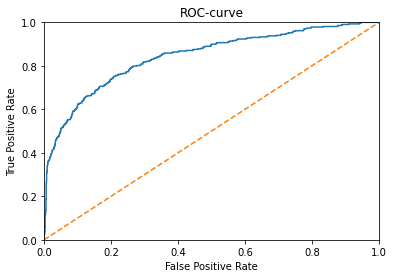

In [32]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

In [33]:
roc_auc_score(target_test, probabilities_one_test)

0.842706373738046

Conclusions: The constructed model has a rather high value of ROC-AUC, as well as the value f1=0.6088992974238876, which exceeds the required threshold, therefore the model meets the set quality requirements.